In [13]:
from IPython.display import display
import pandas as pd
import numpy as np

df=pd.read_csv("savant_data_2021_2023.csv")
df["game_date"] = pd.to_datetime(df["game_date"])
df["season"] = df["game_date"].dt.year  # Extract season year

In [18]:
# Aggregate the unique batters faced and count distinct games for each pitcher per season
unique_batters_per_season = (
    df.drop_duplicates(subset=["season", "batter", "game_pk", "pitcher"])
    .groupby(['pitcher', 'season'])
    .agg(
        Batters_Faced_by_pitcher=("batter", "size"),  # Count unique batters faced
        games_played_pitcher=("game_pk", "nunique")  # Count unique games
    )
    .reset_index()
)
# Count distinct at-bats and distinct games for each batter per season
batting_time_count = (
    df.drop_duplicates(subset=["season", "batter", "game_pk", "at_bat_number"])
    .groupby(["batter", "season"])
    .agg(
        Plate_Appearence_by_batter=("at_bat_number", "size"),  # Count unique at-bats
        games_played_batter=("game_pk", "nunique")       # Count unique games
    )
    .reset_index()
)

# Count of batters (pitches thrown) for each pitcher in a season
pitcher_pitches_thrown = (
    df.groupby(['pitcher', 'season'])
    .agg(
        pitches_thrown=("batter", "count")  # Count of batters faced
    )
    .reset_index()
)


# Count of pitchers (balls faced) for each batter in a season
batter_balls_faced = (
    df.groupby(['batter', 'season'])
    .agg(
        balls_faced=("pitcher", "count")  # Count of pitchers faced
    )
    .reset_index()
)

# Merge pitches thrown into unique batters faced per season
unique_batters_per_season = unique_batters_per_season.merge(
    pitcher_pitches_thrown,
    on=['pitcher', 'season'],
    how='left'
)

# Merge balls faced into distinct at-bats per season
batting_time_count = batting_time_count.merge(
    batter_balls_faced,
    on=['batter', 'season'],
    how='left'
)

# Strike zone count
df["is_in_strike_zone"] = df["zone"].isin([1, 2, 3, 4, 5, 6, 7, 8, 9])
strike_zone_count = df.groupby(["pitcher", "season"])["is_in_strike_zone"].sum()
unique_batters_per_season =unique_batters_per_season.merge(
    strike_zone_count,
    on=['pitcher', 'season'],
    how='left'
)


# strike out count
strikeout_count = df.groupby(["pitcher", "season"])["type"].apply(lambda x: (x == 'S').sum()).reset_index(name="strikeouts_by_pitcher")

unique_batters_per_season =unique_batters_per_season.merge(
    strikeout_count,
    on=['pitcher', 'season'],
    how='left'
)

# --- STEP 3: Identify Two-Way Players ---
# Get unique lists of batters and pitchers (per season)
batters = set(df["batter"].dropna().unique())
pitchers = set(df["pitcher"].dropna().unique())

# Identify players who appeared as both batters and pitchers
two_way_players = batters.intersection(pitchers)

# --- STEP 4: Merge Batting and Pitching Stats ---
# Rename columns for consistent merging
batting_time_count.rename(columns={"batter": "player"}, inplace=True)
unique_batters_per_season.rename(columns={"pitcher": "player"}, inplace=True)

# Merge batting and pitching stats by season
playing_time = pd.merge(
    batting_time_count,
    unique_batters_per_season,
    on=["season", "player"],
    how="outer"
).fillna(0)

playing_time["total_playing_time"] = playing_time["Batters_Faced_by_pitcher"] + playing_time["Plate_Appearence_by_batter"]

# Add a column to identify two-way players
playing_time["two_way_player"] = playing_time["player"].isin(two_way_players)

# # --- STEP 6: Handle Players with Single Roles ---
# # Optional: Add flags for role-specific players
# playing_time["is_batter_only"] = (playing_time["distinct_at_bats"] > 0) & (playing_time["distinct_at_pitch"] == 0)
# playing_time["is_pitcher_only"] = (playing_time["distinct_at_pitch"] > 0) & (playing_time["distinct_at_bats"] == 0)

display(playing_time.sort_values(by="total_playing_time", ascending=False))


,player,season,Plate_Appearence_by_batter,games_played_batter,balls_faced,Batters_Faced_by_pitcher,games_played_pitcher,pitches_thrown,is_in_strike_zone,strikeouts_by_pitcher,total_playing_time,two_way_player
1643,18396fcf5f98aac97ec6127f7924868d3ef7bd9e,2022,655.0,157.0,2546.0,253.0,28.0,2629.0,1352.0,1330.0,908.0,True
136,18396fcf5f98aac97ec6127f7924868d3ef7bd9e,2021,626.0,154.0,2594.0,210.0,23.0,2027.0,1044.0,973.0,836.0,True
3143,18396fcf5f98aac97ec6127f7924868d3ef7bd9e,2023,582.0,135.0,2321.0,203.0,23.0,2094.0,1088.0,1040.0,785.0,True
3465,514eeb6e6c17085fc1adabf03f1adca32318411f,2023,753.0,162.0,2799.0,0.0,0.0,0.0,0.0,0.0,753.0,False
4021,b4246bd7233f08e749626eb0b7647d295f2e37b7,2023,732.0,159.0,2782.0,0.0,0.0,0.0,0.0,0.0,732.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2279,852074cf280f7e76d76696a7a3e2ed58bb096c62,2022,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,False
704,776addf45775078d8c8694a7bd333845153f5529,2021,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,False
4350,eba4034f8b499f74e06bd5febb22a6934a8f7bac,2023,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,True
711,78576937fe7d731544ca5bd0f668e5f6b3dda9f3,2021,1.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,False


In [12]:
# # Group by season and player type, then calculate descriptive statistics
# descriptive_stats = playing_time.groupby(
#     ['season', 'two_way_player', 'is_batter_only', 'is_pitcher_only']
# )['total_playing_time'].describe()

# # Display the statistics
# display(descriptive_stats)

count        mean  \
season two_way_player is_batter_only is_pitcher_only                      
2021   False          False          True             454.0  113.828194   
                      True           False            531.0  269.395480   
       True           False          False            452.0  189.986726   
                                     True               3.0  188.000000   
                      True           False             66.0  304.500000   
2022   False          False          True             493.0  119.758621   
                      True           False            564.0  269.739362   
       True           False          False             71.0  250.521127   
                                     True             307.0  178.908795   
                      True           False             58.0  246.068966   
2023   False          False          True             544.0  129.000000   
                      True           False            549.0  296.744991   
       True           False          False             65.0  215.723077   
                                     True             254.0  175.708661   
                      True           False             42.0  209.357143   

                                                             std   min  \
season two_way_player is_batter_only is_pitcher_only                     
2021   False          False          True              94.894604   3.0   
                      True           False            217.707641   1.0   
       True           False          False            112.065173   7.0   
                                     True             119.778963  50.0   
                      True           False            192.539646  11.0   
2022   False          False          True              91.756485   3.0   
                      True           False            219.634909   1.0   
       True           False          False            158.084142  19.0   
                                     True              91.129002   5.0   
                      True           False            197.458578   1.0   
2023   False          False          True              94.798555   2.0   
                      True           False            221.423251   1.0   
       True           False          False            155.310124  22.0   
                                     True              95.593020   4.0   
                      True           False            182.933924   1.0   

                                                         25%    50%     75%  \
season two_way_player is_batter_only is_pitcher_only                          
2021   False          False          True              28.25   85.0  201.00   
                      True           False             62.00  229.0  462.50   
       True           False          False             97.75  193.5  269.00   
                                     True             149.50  249.0  257.00   
                      True           False            142.00  302.0  451.50   
2022   False          False          True              33.00   97.0  203.00   
                      True           False             59.75  226.0  455.50   
       True           False          False            141.00  217.0  326.00   
                                     True              94.50  199.0  261.00   
                      True           False             83.00  198.0  390.75   
2023   False          False          True              45.00  107.0  213.25   
                      True           False             84.00  279.0  488.00   
       True           False          False             97.00  191.0  297.00   
                                     True              90.25  191.0  262.00   
                      True           False             65.25  148.5  348.75   

                                                        max  
season two_way_player is_batter_only is_pitcher_only         
2021   False          False          True          

In [4]:
# Count the number of players who are only batters, only pitchers, and two-way players
batter_only_count = playing_time["is_batter_only"].sum()
pitcher_only_count = playing_time["is_pitcher_only"].sum()
two_way_player_count = playing_time["two_way_player"].sum()

print("Count of batter-only players:", batter_only_count)
print("Count of pitcher-only players:", pitcher_only_count)
print("Count of two-way players:", two_way_player_count)

Count of batter-only players: 1810
Count of pitcher-only players: 2055
Count of two-way players: 1318


In [30]:
record_count = len(df)
print("Count of records in df:", record_count)

Count of records in df: 2136337


In [19]:
df['woba_value'].fillna(0, inplace=True)
df['woba_denom'].fillna(0, inplace=True)
df['babip_value'].fillna(0, inplace=True)
df['iso_value'].fillna(0, inplace=True)
df['estimated_ba_using_speedangle'].fillna(0, inplace=True)
df['estimated_woba_using_speedangle'].fillna(0, inplace=True)

C:\Users\siddh\AppData\Local\Temp\ipykernel_19700\908619352.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['woba_value'].fillna(0, inplace=True)
C:\Users\siddh\AppData\Local\Temp\ipykernel_19700\908619352.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when

### New Features

In [20]:
df['total_break'] = np.sqrt(df['pfx_x']**2 + df['pfx_z']**2)
df['velocity_drop'] = df['release_speed'] - df['effective_speed']
df['on_edge'] = ((abs(df['plate_x']) > 0.7) & (df['plate_z'] > df['sz_bot'] + 0.3) & (df['plate_z'] < df['sz_top'] - 0.3))
df['strike_zone_location'] = np.sqrt(df['plate_x']**2 + (df['plate_z'] - df['sz_bot'])**2)
df['Run_production_impact'] =  df['post_bat_score'] - df['bat_score']
mapping = {
    1: 'Weak',
    2: 'Topped',
    3: 'Under',
    4: 'Flare/Burner',
    5: 'Solid Contact',
    6: 'Barrel'
}

# Replace numeric values with names
df['launch_speed_angle_new'] = df['launch_speed_angle'].map(mapping)


In [31]:
import numpy as np
import pandas as pd

# Aggregating metrics for players per season
batter_season_metrics = (
    df.groupby(["batter", "season"])
    .agg(
        # Performance metrics
        total_woba_value=("woba_value", "sum"),  # Total wOBA contribution
        total_woba_denom=("woba_denom", "sum"),  # Total wOBA denominator
        total_babip_value=("babip_value", "sum"),  # Total BABIP contribution
        total_iso_value=("iso_value", "sum"),  # Total ISO contribution


        # Run production
        total_run_production=("Run_production_impact", "sum"),  # Total run production impact

        # Launch angle categories (counts of events by type)
        weak_contact_count_pitcher=("launch_speed_angle_new", lambda x: (x == "Weak").sum()),
        solid_contact_count_pitcher=("launch_speed_angle_new", lambda x: (x == "Solid Contact").sum()),
        barrel_count_pitcher=("launch_speed_angle_new", lambda x: (x == "Barrel").sum())
    )
    .reset_index()
)
pitcher_season_metrics = (
    df.groupby(["pitcher", "season"])
    .agg(
        total_babip_value=("babip_value", "sum"),  # Total BABIP contribution
        # Contact and pitch metrics
        avg_total_break=("total_break", "mean"),  # Average total break
        avg_velocity_drop=("velocity_drop", "mean"),  # Average velocity drop
        strike_zone_location_mean=("strike_zone_location", "mean"),  # Avg. strike zone distance
        pitches_on_edge=("on_edge", "sum"),  # Count of pitches on the edge of the strike zone


        # Launch angle categories (counts of events by type)
        weak_contact_count_batter=("launch_speed_angle_new", lambda x: (x == "Weak").sum()),
        topped_contact_count_batter=("launch_speed_angle_new", lambda x: (x == "Topped").sum()),
        under_contact_count_batter=("launch_speed_angle_new", lambda x: (x == "Under").sum()),
        flare_burner_contact_count_batter=("launch_speed_angle_new", lambda x: (x == "Flare/Burner").sum()),
        solid_contact_count_batter=("launch_speed_angle_new", lambda x: (x == "Solid Contact").sum()),
        barrel_count_batter=("launch_speed_angle_new", lambda x: (x == "Barrel").sum())
    )
    .reset_index()
)
# Display aggregated metrics per player and season
print(pitcher_season_metrics.head())


                                    pitcher  season  total_babip_value  \
0  007d7209f1d3287648e11f52c5a5148732f7a791    2021               13.0   
1  007d7209f1d3287648e11f52c5a5148732f7a791    2022               12.0   
2  007dcc596b82af90fd37f3413e98812b87a6b305    2021                1.0   
3  007dcc596b82af90fd37f3413e98812b87a6b305    2022                5.0   
4  007dcc596b82af90fd37f3413e98812b87a6b305    2023               42.0   

   avg_total_break  avg_velocity_drop  strike_zone_location_mean  \
0         1.313180          -1.103980                   1.461342   
1         1.278204          12.614644                   1.504396   
2         1.573777           0.137037                   1.314674   
3         1.587169           0.566013                   1.328496   
4         1.538237           0.704103                   1.380921   

   pitches_on_edge  weak_contact_count_batter  topped_contact_count_batter  \
0               29                          1                       

In [32]:
final_df = playing_time.merge(
    batter_season_metrics,
    left_on=['player', 'season'],
    right_on=['batter', 'season'],
    how='left'
)

display(final_df)

,player,season,Plate_Appearence_by_batter,games_played_batter,balls_faced,Batters_Faced_by_pitcher,games_played_pitcher,pitches_thrown,is_in_strike_zone,strikeouts_by_pitcher,...,two_way_player,batter,total_woba_value,total_woba_denom,total_babip_value,total_iso_value,total_run_production,weak_contact_count_pitcher,solid_contact_count_pitcher,barrel_count_pitcher
0,003af1e4636109b822c9acfa703cb517c46d89fc,2021,163.0,44.0,618.0,0.0,0.0,0.0,0.0,0.0,...,False,003af1e4636109b822c9acfa703cb517c46d89fc,49.10,162.0,33.0,20.0,14.0,8.0,3.0,7.0
1,007d7209f1d3287648e11f52c5a5148732f7a791,2021,0.0,0.0,0.0,55.0,10.0,201.0,110.0,94.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,007dcc596b82af90fd37f3413e98812b87a6b305,2021,0.0,0.0,0.0,6.0,2.0,27.0,17.0,17.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00e99b6a19161174f9f6520a80783c70236d8403,2021,36.0,14.0,136.0,0.0,0.0,0.0,0.0,0.0,...,False,00e99b6a19161174f9f6520a80783c70236d8403,12.35,36.0,8.0,4.0,2.0,1.0,0.0,2.0
4,01062805175a65bbfb5e2024853137219296e26c,2021,559.0,137.0,1877.0,0.0,0.0,0.0,0.0,0.0,...,True,01062805175a65bbfb5e2024853137219296e26c,186.35,558.0,133.0,61.0,63.0,15.0,32.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,fe6eac0778f476c3f1ffe6a1fd637f077573e077,2023,531.0,119.0,2205.0,0.0,0.0,0.0,0.0,0.0,...,False,fe6eac0778f476c3f1ffe6a1fd637f077573e077,178.75,527.0,94.0,74.0,64.0,10.0,27.0,27.0
4449,fe80da2e964fa0782b5d30725105f59444a90261,2023,200.0,50.0,761.0,0.0,0.0,0.0,0.0,0.0,...,False,fe80da2e964fa0782b5d30725105f59444a90261,68.10,199.0,29.0,48.0,29.0,1.0,9.0,21.0
4450,ff3b7d21e60c24b6e926e3ffc3fbeb78cc9e4057,2023,0.0,0.0,0.0,258.0,68.0,929.0,509.0,442.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4451,ffa57541bf6d7030fdf7206f4aa0141a2c918647,2023,0.0,0.0,0.0,217.0,24.0,2100.0,1045.0,989.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
final_df = final_df.merge(
    pitcher_season_metrics,
    left_on=['player', 'season'],
    right_on=['pitcher', 'season'],
    how='left'
)

display(final_df)

,player,season,Plate_Appearence_by_batter,games_played_batter,balls_faced,Batters_Faced_by_pitcher,games_played_pitcher,pitches_thrown,is_in_strike_zone,strikeouts_by_pitcher,...,avg_total_break,avg_velocity_drop,strike_zone_location_mean,pitches_on_edge,weak_contact_count_batter,topped_contact_count_batter,under_contact_count_batter,flare_burner_contact_count_batter,solid_contact_count_batter,barrel_count_batter
0,003af1e4636109b822c9acfa703cb517c46d89fc,2021,163.0,44.0,618.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,007d7209f1d3287648e11f52c5a5148732f7a791,2021,0.0,0.0,0.0,55.0,10.0,201.0,110.0,94.0,...,1.313180,-1.103980,1.461342,29.0,1.0,10.0,12.0,12.0,0.0,4.0
2,007dcc596b82af90fd37f3413e98812b87a6b305,2021,0.0,0.0,0.0,6.0,2.0,27.0,17.0,17.0,...,1.573777,0.137037,1.314674,8.0,0.0,3.0,0.0,0.0,0.0,0.0
3,00e99b6a19161174f9f6520a80783c70236d8403,2021,36.0,14.0,136.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01062805175a65bbfb5e2024853137219296e26c,2021,559.0,137.0,1877.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4448,fe6eac0778f476c3f1ffe6a1fd637f077573e077,2023,531.0,119.0,2205.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4449,fe80da2e964fa0782b5d30725105f59444a90261,2023,200.0,50.0,761.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4450,ff3b7d21e60c24b6e926e3ffc3fbeb78cc9e4057,2023,0.0,0.0,0.0,258.0,68.0,929.0,509.0,442.0,...,1.125692,0.885129,1.431944,159.0,13.0,94.0,27.0,46.0,3.0,9.0
4451,ffa57541bf6d7030fdf7206f4aa0141a2c918647,2023,0.0,0.0,0.0,217.0,24.0,2100.0,1045.0,989.0,...,1.390118,-0.699333,1.289189,350.0,19.0,87.0,143.0,85.0,27.0,28.0


In [35]:
# filtered_batting_summary = playing_time[
#     (playing_time["player"] == '0014c193005b425aaad55358686fb0dd1a4a0755') & 
#     (playing_time["season"] == 2023)
# ]
# display(filtered_batting_summary)    

final_df['two_way_player'] = final_df['two_way_player'].astype(int)


In [39]:
! pip install xgboost
! pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/124.9 MB 2.4 MB/s eta 0:00:52
   ---------------------------------------- 1.3/124.9 MB 2.4 MB/s eta 0:00:52
    --------------------------------------- 1.8/124.9 MB 2.3 MB/s eta 0:00:54
    --------------------------------------- 2.4/124.9 MB 2.5 MB/s eta 0:00:50
   - -------------------------------------- 3.1/124.9 MB 2.5 MB/s eta 0:00:49
   - -------------------------------------- 3.7/124.9 MB 2.6 MB/s eta 0:00:47
   - -------------------------------------- 4.2/124.9 MB 2.6 MB/s eta 0:00:47
   - -------------------------------------- 4.7/124.9 MB 2.6 MB/s eta 0:00:47
   - -------------------------------------- 5.5/124.9 MB 2.7 MB/s eta 0:00:45
   - -------------------------------------- 6.0/124.9 MB 2.7 MB/s eta 0:00:45



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\siddh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.4 MB 5.6 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.4 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\siddh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


XGBoost - MAE: 3.9959, RMSE: 6.5893
Random Forest - MAE: 3.8200, RMSE: 8.3465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3984
[LightGBM] [Info] Number of data points in the train set: 2999, number of used features: 26
[LightGBM] [Info] Start training from score 199.873291
LightGBM - MAE: 4.1389, RMSE: 7.6913


<Figure size 1000x600 with 0 Axes>

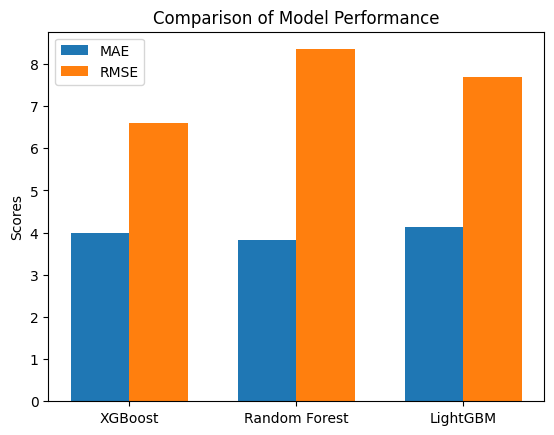

In [41]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Split by season to avoid data leakage
train_data = final_df[final_df['season'] < 2023]
test_data = final_df[final_df['season'] == 2023]

# Define features and target
X_train = train_data.drop(columns=['player', 'season', 'total_playing_time','Plate_Appearence_by_batter','Batters_Faced_by_pitcher','batter','pitcher'])
y_train = train_data['total_playing_time']

X_test = test_data.drop(columns=['player', 'season', 'total_playing_time','Plate_Appearence_by_batter','Batters_Faced_by_pitcher','batter','pitcher'])
y_test = test_data['total_playing_time']

# Define models
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
}

# Initialize results dictionary
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[model_name] = {
        'MAE': mae,
        'RMSE': rmse
    }
    
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Plot the performance comparison
mae_values = [result['MAE'] for result in results.values()]
rmse_values = [result['RMSE'] for result in results.values()]

plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()

bars1 = ax.bar(x - width/2, mae_values, width, label='MAE')
bars2 = ax.bar(x + width/2, rmse_values, width, label='RMSE')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models.keys())
ax.legend()

plt.show()


In [34]:
print(final_df.columns)

Index(['player', 'season', 'Plate_Appearence_by_batter', 'games_played_batter',
       'balls_faced', 'Batters_Faced_by_pitcher', 'games_played_pitcher',
       'pitches_thrown', 'is_in_strike_zone', 'strikeouts_by_pitcher',
       'total_playing_time', 'two_way_player', 'batter', 'total_woba_value',
       'total_woba_denom', 'total_babip_value_x', 'total_iso_value',
       'total_run_production', 'weak_contact_count_pitcher',
       'solid_contact_count_pitcher', 'barrel_count_pitcher', 'pitcher',
       'total_babip_value_y', 'avg_total_break', 'avg_velocity_drop',
       'strike_zone_location_mean', 'pitches_on_edge',
       'weak_contact_count_batter', 'topped_contact_count_batter',
       'under_contact_count_batter', 'flare_burner_contact_count_batter',
       'solid_contact_count_batter', 'barrel_count_batter'],
      dtype='object')
